In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import autokeras as ak
import json
import os
import time
from datetime import datetime
from matplotlib import pyplot
from sklearn.metrics import classification_report

In [2]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow.")

import tensorflow as tf
print("\nTensorFlow version: ", tf.__version__)
print("\nIs GPU available?", tf.test.is_gpu_available())
print("\nNum GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("\nPhysical Devices: ", tf.config.list_physical_devices('GPU'))

from tensorflow.python.client import device_lib
print("\nLocal devices:", device_lib.list_local_devices())

Please install GPU version of TensorFlow.

TensorFlow version:  2.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

Is GPU available? False

Num GPUs Available:  0

Physical Devices:  []

Local devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 802706703021577680
xla_global_id: -1
]


In [3]:
SEED        = 10
folder_name = 'filtered_by_label'
limit_rows  = None
n_cpus      = os.cpu_count()

In [4]:
print(f"Execution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution started at 2022-03-11 03:04:06.


In [5]:
def load_csv(subset,folder=folder_name):
    if limit_rows is None:
        full_filename = f'../../Data Preprocessing/{folder}/iot23_combined_{subset}.csv'
    else:
        full_filename = f'../../Data Preprocessing/{folder}/iot23_combined_{int(limit_rows/1000)}k_{subset}.csv'
    
    df = pd.read_table(filepath_or_buffer=full_filename, header=None, sep=',').infer_objects().to_numpy()
    
    return df.ravel() if df.shape[1] == 1 else df

In [6]:
X_train, X_test, y_train, y_test = load_csv('X_train'), load_csv('X_test'), load_csv('y_train'), load_csv('y_test')

print('X_train',X_train.shape,'\ny_train',y_train.shape)
print('X_test',X_test.shape,'\ny_test',y_test.shape)

X_train (7014497, 15) 
y_train (7014497,)
X_test (1753625, 15) 
y_test (1753625,)


In [7]:
clf = ak.AutoModel(inputs=[ak.StructuredDataInput()],
                   outputs=[ak.ClassificationHead()],
                   overwrite=True,
                   max_trials=10,
                   seed=SEED
)

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-4)

print(f"Fitting started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

clf.fit(X_train, y_train, batch_size=256, callbacks=[early_stopping], epochs=100, validation_split=0.25)

print(f"Fitting finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Trial 10 Complete [00h 10m 01s]
val_loss: 0.07441079616546631

Best val_loss So Far: 0.016449101269245148
Total elapsed time: 03h 23m 36s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0505 - accuracy: 0.9838
Epoch 2/100
27401/27401 [==============================] - 32s 1ms/step - loss: 0.0207 - accuracy: 0.9930
Epoch 3/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0203 - accuracy: 0.9932
Epoch 4/100
27401/27401 [==============================] - 32s 1ms/step - loss: 0.0197 - accuracy: 0.9933
Epoch 5/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0195 - accuracy: 0.9933
Epoch 6/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0192 - accuracy: 0.9934
Epoch 7/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0189 - accuracy: 0.9934
Epoch 8/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.

27401/27401 [==============================] - 33s 1ms/step - loss: 0.0130 - accuracy: 0.9965
Epoch 77/100
27401/27401 [==============================] - 32s 1ms/step - loss: 0.0129 - accuracy: 0.9965
Epoch 78/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0116 - accuracy: 0.9965
Epoch 79/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0116 - accuracy: 0.9965
Epoch 80/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0112 - accuracy: 0.9965
Epoch 81/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0129 - accuracy: 0.9966
Epoch 82/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0127 - accuracy: 0.9965
Epoch 83/100
27401/27401 [==============================] - 33s 1ms/step - loss: 0.0114 - accuracy: 0.9965
Epoch 84/100
27401/27401 [==============================] - 32s 1ms/step - loss: 0.0114 - accuracy: 0.9965
Epoch 85/100
27401/27401 [========================

In [35]:
output_filename = 'model-autokeras-am-filtered_by_label'
class_names = ['Benign','DDoS','Okiru','PartOfAHorizontalPortScan']

In [36]:
print(f"Evaluation started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

print(f'\n**** AutoKeras evaluation ****')
print(clf.evaluate(X_test, y_test, batch_size=256))

print(f'\n**** Scikit-learn evaluation ****')
y_pred = [int(x) for x in clf.predict(X_test, batch_size=256)]
print(classification_report(y_test, y_pred, digits=4, target_names=class_names, zero_division=0))
with open(f'{output_filename}_report.json', 'w') as fp:
    json.dump(classification_report(y_test, y_pred, output_dict=True, target_names=class_names, zero_division=0), fp)

print(f"Evaluation finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Evaluation started at 2022-03-11 10:23:35.

**** AutoKeras evaluation ****
6851/6851 [==============================] - 6s 877us/step - loss: 0.0316 - accuracy: 0.9966
[0.03158176690340042, 0.9965745210647583]

**** Scikit-learn evaluation ****
6851/6851 [==============================] - 7s 986us/step
                           precision    recall  f1-score   support

                   Benign     0.9976    0.9957    0.9967    852507
                     DDoS     0.9999    0.9992    0.9996    433190
                    Okiru     0.6549    0.8052    0.7223      2988
PartOfAHorizontalPortScan     0.9942    0.9970    0.9956    464940

                 accuracy                         0.9966   1753625
                macro avg     0.9117    0.9493    0.9285   1753625
             weighted avg     0.9967    0.9966    0.9966   1753625

Evaluation finished at 2022-03-11 10:24:00.


In [37]:
best_model = clf.export_model()

In [38]:
best_model.metrics_names

['loss', 'accuracy']

In [39]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 15)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 15)               31        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                512       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [40]:
with open(f'{output_filename}_model.json', 'w') as fp:
    json.dump(best_model.to_json(), fp)

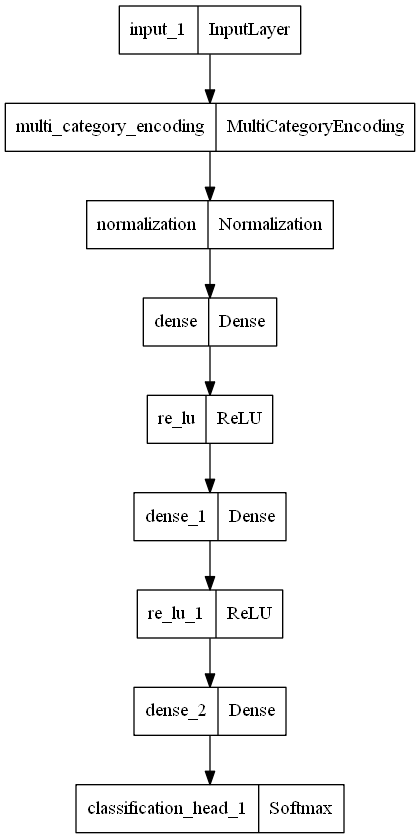

In [41]:
tf.keras.utils.plot_model(best_model, to_file=f'{output_filename}.png')

In [42]:
best_model.save(f'{output_filename}')

INFO:tensorflow:Assets written to: model-autokeras-am-filtered_by_label\assets


In [43]:
print(f"Execution finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution finished at 2022-03-11 10:24:03.
